In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation

# Enable interactive plot
#%matplotlib notebook

## 1. create all frames

In [2]:
# there are two arrays to deal with in this program: 'scene' and 'frame'.
# 'scene' holds the compressed information of wether each block is white or black.
# 'frame' is a larger version of 'scene' used for visualizaion;
# each block of 'frame' corresponds to one entry of 'scene'.

# below method generates 'scene' based on primary information and draws 'frame' as well
def moving_bar(instance, scene_sz=5, frame_sz=1024, plot=False, ax=None):
    # calculate size of each block in the frame corresponding to each entry of the scene
    rec_sz = frame_sz//scene_sz
    
    # prepare the scene
    bar_pos = instance%scene_sz
    scene = np.zeros((scene_sz,scene_sz))
    scene[:,bar_pos] = 1

    if plot:
        # prepare frame based on the scene
        frame = 255 * np.ones(shape=[frame_sz, frame_sz, 3], dtype=np.uint8)
        for i in range(scene_sz):
            for j in range(scene_sz):
                cv2.rectangle(frame, pt1=(rec_sz*j,rec_sz*i), pt2=(rec_sz*(j+1),rec_sz*(i+1)), color=(255*(1-scene[i,j]),255*(1-scene[i,j]),255*(1-scene[i,j])), thickness= -1)

        # show frame
        ax.imshow(frame)
    
    return scene

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

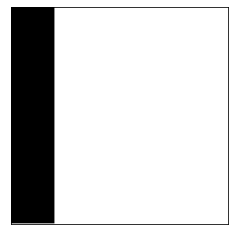

In [3]:
# test above function
#fig = plt.figure(figsize=[6,6])
fig, ax = plt.subplots()
plt.xticks([])
plt.yticks([])
moving_bar(instance=0, scene_sz=5, frame_sz=1024, plot=True, ax=ax)

In [4]:
# generate all possible scenes
scene_sz = 5
scenes = np.array([moving_bar(instance=0, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)])

for i in range(1, scene_sz):
    scenes = np.append(scenes, [moving_bar(instance=i, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)], axis=0)

scenes    

array([[[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]],

       [[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]])

## 2. create the underlying graph

In [5]:
# graph is implemented by a dictionary;
# keys are vertices and values are out- and in- edges of the corresponding vertex.
# vertices and edges are weighted. edges are directed as well.
class graph:
    
    # define vertex object
    class vertex:
        def __init__(self, vid=None, weight=None):
            self.vid = vid
            self.weight = weight
        
        def getID(self):
            return self.vid
        
        def getWeight(self):
            return self.weight
        
        def setID(self, vid):
            self.vid = vid
            
        def setWeight(self, weight):
            self.weight = weight
            
    # define edge object
    class edge:
        def __init__(self, edge=(None, None), weight=None):
            self.vrtx1 = edge[0]
            self.vrtx2 = edge[1]
            self.weight = weight
            
        def getEdge(self):
            return (self.vrtx1, self.vrtx2)
        
        def getWeight(self):
            return self.weight
        
        def setVertex1(self, vrtx1):
            self.vrtx1 = vrtx1
        
        def setVertex2(self, vrtx2):
            self.vrtx2 = vrtx2
        
        def setWeight(self, weight):
            self.weight = weight
            
             
    # graph constructor 
    def __init__(self,gdict=None):
        if gdict is None:
            gdict = {}
        self.gdict = gdict
    
    # return a list of vertices by their IDs
    def vertices(self):
        return [vertex.getID() for vertex in self.gdict.keys()]
    
    # return a list of edges
    def edges(self):
        return self.findedges()
    
    # return the whole dictionary
    def dictionary(self):
        cdict = {}
        for vertex in self.gdict.keys():
            outedges = [e.getEdge() for e in self.gdict[vertex]['out']]
            inedges = [e.getEdge() for e in self.gdict[vertex]['in']]
            cdict[vertex.getID()] = {'out': outedges, 'in': inedges}
        return cdict
    
    # import a whole dictionary
    def imprt(self, gdict):
        print('please implement me!')

    
    # return weight of a vertex
    def getVertexWeight(self, vrtx, show_msgs=True):
        for vertex in self.gdict:
            if vertex.getID() == vrtx:
                return vertex.getWeight()
        if show_msgs:
            print('vertex {} does not exist.'.format(vrtx))
            
    # return weight of an edge
    def getEdgeWeight(self, edge, show_msgs=True):
        (vrtx1, vrtx2) = edge
        for vertex in self.gdict:
            if vertex.getID() == vrtx1:
                for e in self.gdict[vertex]['out']:
                    if e.getEdge() == (vrtx1, vrtx2):
                        return e.getWeight()
        if show_msgs:
            print('edge {} does not exist'.format((vrtx1, vrtx2)))
    
    # edit a vertex weight (new weight is 0 if not specified)
    def setVertexWeight(self, vrtx, weight=None, show_msgs=True):
        if weight==None:
            weight = 0
            
        for vertex in self.gdict:
            if vertex.getID() == vrtx:
                vertex.setWeight(weight)
                return
        if show_msgs:
            print('vertex {} does not exist'.format(vrtx))
            
    # edit an edge weight (new weight is 1 if not specified)
    def setEdgeWeight(self, edge, weight=None, show_msgs=True):
        if weight==None:
            weight = 1
            
        (vrtx1, vrtx2) = edge
        for vertex in self.gdict:
            if vertex.getID() == vrtx1:
                for e in self.gdict[vertex]['out']:
                    if e.getEdge() == (vrtx1, vrtx2):
                        e.setWeight(weight)
                        return
        if show_msgs:
            print('edge {} does not exist'.format((vrtx1, vrtx2)))
    
    # Add new vertex (weight is 0 if not specified)
    def addVertex(self, vid=None, weight=None, show_msgs=True):
        if vid==None:
            vid=len(self.gdict)
            while vid in self.vertices():
                vid = vid + 1
                
        if weight==None:
            weight = 0
            
        if vid in self.vertices():
            if show_msgs:
                print('vertex id {} already exists'.format(vid))
        else:
            vrtx = self.vertex(vid=vid, weight=weight)
            self.gdict[vrtx] = {'out': [], 'in': []}
    
    # Add new directed edge (weight is 1 if not specificed)
    def addEdge(self, edge, weight=None, show_msgs=True):
        if weight==None:
            weight = 1
        (vrtx1, vrtx2) = edge
        
        if vrtx1 not in self.vertices():
            if show_msgs:
                print("vertex {} does not exist".format(vrtx1))     
        elif vrtx2 not in self.vertices():
            if show_msgs:
                print("vertex {} does not exist".format(vrtx2))  
        elif (vrtx1, vrtx2) in self.edges():
            if show_msgs:
                print("edge {} already exists".format((vrtx1,vrtx2)))
        else:
            e = self.edge(edge=(vrtx1, vrtx2), weight=weight)
            for vertex in self.gdict.keys():
                if vertex.getID() == vrtx1:
                    self.gdict[vertex]['out'].append(e)
                elif vertex.getID() == vrtx2:
                    self.gdict[vertex]['in'].append(e)
            
    # Add new undirected edge (weight is 1 if not specified)
    def addUndirectedEdge(self, edge, weight=None, show_msgs=True):
        if weight==None:
            weight = 1
        (vrtx1, vrtx2) = edge
        
        if vrtx1 not in self.vertices():
            if show_msgs:
                print("vertex {} does not exist".format(vrtx1))     
        elif vrtx2 not in self.vertices():
            if show_msgs:
                print("vertex {} does not exist".format(vrtx2))
        elif (vrtx1, vrtx2) in self.edges() and (vrtx2, vrtx1) in self.edges():
            if show_msgs:
                print("undirected edge {} already exists".format((vrtx1,vrtx2)))
        else:
            if (vrtx1, vrtx2) not in self.edges():
                e = self.edge(edge=(vrtx1, vrtx2), weight=weight)
                for vertex in self.gdict.keys():
                    if vertex.getID() == vrtx1:
                        self.gdict[vertex]['out'].append(e)
                    elif vertex.getID() == vrtx2:
                        self.gdict[vertex]['in'].append(e)
                        
            if (vrtx2, vrtx1) not in self.edges():
                e = self.edge(edge=(vrtx2, vrtx1), weight=weight)
                for vertex in self.gdict.keys():
                    if vertex.getID() == vrtx2:
                        self.gdict[vertex]['out'].append(e)
                    elif vertex.getID() == vrtx1:
                        self.gdict[vertex]['in'].append(e)
            

    # List the edge names
    def findedges(self):
        edgename = []
        for vertex in self.gdict:
            for e in self.gdict[vertex]['out']:
                edgename.append(e.getEdge())
        return edgename

In [6]:
# test adding vertices to the graph
def test_graph_1(show_msgs=True):
    g = graph()
    assert g.vertices() == []
    assert g.edges() == []
    assert g.dictionary() == {}
    
    g.addVertex()
    assert g.getVertexWeight(vrtx=0) == 0
    assert g.vertices() == [0]
    
    g.addVertex()
    g.addVertex(weight=1.5)
    g.addVertex(vid='2', weight=3)
    g.addVertex(weight='4')
    assert g.vertices() == [0, 1, 2, '2', 4]
    assert g.getVertexWeight(vrtx=2) == 1.5
    assert g.getVertexWeight(vrtx='2') == 3
    assert g.getVertexWeight(vrtx=4) == '4'
    
    g.getVertexWeight(vrtx=6, show_msgs=show_msgs)
    
    g.addVertex(vid=6)
    g.addVertex()
    assert g.vertices() == [0, 1, 2, '2', 4, 6, 7]
    
    g.addVertex(vid=7, show_msgs=False)
    assert g.vertices() == [0, 1, 2, '2', 4, 6, 7]
    
# test adding edges to the graph
def test_graph_2(show_msgs=True):
    g = graph()
    assert g.edges() == []
    
    for i in range(5):
        g.addVertex()
    g.addEdge((0,1))
    g.addEdge((1,0), weight=2)
    g.addEdge((2,3), weight=5)
    assert g.vertices() == [0, 1, 2, 3, 4]
    assert g.edges() == [(0, 1), (1, 0), (2, 3)]
    assert g.dictionary()[0] == {'out': [(0, 1)], 'in': [(1, 0)]}
    assert g.dictionary()[1] == {'out': [(1, 0)], 'in': [(0, 1)]}
    assert g.dictionary()[2] == {'out': [(2, 3)], 'in': []}
    assert g.dictionary()[3] == {'out': [], 'in': [(2, 3)]}
    assert g.dictionary()[4] == {'out': [], 'in': []}
    
    assert g.getEdgeWeight((0, 1)) == 1
    assert g.getEdgeWeight((1,0)) == 2
    assert g.getEdgeWeight((2,3)) == 5
    
    g.getEdgeWeight((3,2), show_msgs=show_msgs)
    
    g.addEdge((0,5), show_msgs=show_msgs)
    g.addEdge((6,1), show_msgs=show_msgs)
    g.addEdge((2,3), show_msgs=show_msgs)
    assert g.getEdgeWeight((1,3), show_msgs=show_msgs) == None
    
    g.addUndirectedEdge((4,3),weight=9)
    g.addUndirectedEdge((2,3),weight=5)
    g.addEdge((1,4))
    g.addUndirectedEdge((4,1),weight=3)
    g.addUndirectedEdge((1,0),weight=9, show_msgs=show_msgs)
    assert g.edges() == [(0, 1), (1, 0), (1, 4), (2, 3), (3, 4), (3, 2), (4, 3), (4, 1)]
    
    
# test editting vertex and edge weights
def test_graph_3(show_msgs=True):
    g = graph()
    for i in range(5):
        g.addVertex()
    for i in range(5):
        g.addUndirectedEdge((i,(i+1)%5))
    assert g.vertices() == [0, 1, 2, 3, 4]
    assert g.edges() == [(0, 1), (0, 4), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 0)]
    for i in range(5):
        assert g.getVertexWeight(vrtx=i) == 0
        assert g.getEdgeWeight(edge=(i,(i+1)%5)) == 1
        assert g.getEdgeWeight(edge=((i+1)%5,i)) == 1
        
    g.setVertexWeight(vrtx=2, weight=2)
    g.setVertexWeight(vrtx=1, weight=3)
    g.setVertexWeight(vrtx=7, weight=4, show_msgs=show_msgs)
    g.setEdgeWeight(edge=(0,1), weight=3)
    g.setEdgeWeight(edge=(2,3), weight='a')
    g.setEdgeWeight(edge=(1,3), weight=3, show_msgs=show_msgs)
    assert g.getVertexWeight(vrtx=0) == 0
    assert g.getVertexWeight(vrtx=1) == 3
    assert g.getVertexWeight(vrtx=2) == 2
    assert g.getVertexWeight(vrtx=3) == 0
    assert g.getVertexWeight(vrtx=4) == 0
    assert g.getEdgeWeight(edge=(0,1)) == 3
    assert g.getEdgeWeight(edge=(1,0)) == 1
    assert g.getEdgeWeight(edge=(1,2)) == 1
    assert g.getEdgeWeight(edge=(2,1)) == 1
    assert g.getEdgeWeight(edge=(2,3)) == 'a'
    assert g.getEdgeWeight(edge=(3,2)) == 1
    assert g.getEdgeWeight(edge=(3,4)) == 1
    assert g.getEdgeWeight(edge=(4,3)) == 1
    assert g.getEdgeWeight(edge=(4,0)) == 1
    assert g.getEdgeWeight(edge=(0,4)) == 1
        
    
def test_graph(show_msgs=True):      
    test_graph_1(show_msgs=show_msgs) # adding vertices to the graph
    test_graph_2(show_msgs=show_msgs) # adding edges to the graph
    test_graph_3(show_msgs=show_msgs) # editting vertex and edge weights
    
test_graph(show_msgs=True)

vertex 6 does not exist.
edge (3, 2) does not exist
vertex 5 does not exist
vertex 6 does not exist
edge (2, 3) already exists
edge (1, 3) does not exist
undirected edge (1, 0) already exists
vertex 7 does not exist
edge (1, 3) does not exist


In [7]:
def create_star_graph(scene_sz, show_msgs=True):
    g = graph()
    for i in range(scene_sz**2):
        g.addVertex()
    for i in range(scene_sz):
        for j in range(scene_sz):
            center = i*scene_sz+j
            for k in [-1,1]:
                # left and right nodes
                if (j!=0 or k==1) and (j<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k), show_msgs=show_msgs)

                #up and down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k*scene_sz), show_msgs=show_msgs)

                #right-up and right-down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1) and (j<scene_sz-1):
                    g.addEdge((center, center+k*scene_sz+1), show_msgs=show_msgs)

                #left-up and left-down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1) and (j!=0):
                    g.addEdge((center, center+k*scene_sz-1), show_msgs=show_msgs)

    return g

In [8]:
def test_create_star_graph():
    g = create_star_graph(scene_sz=3)
    assert g.vertices()==[0, 1, 2, 3, 4, 5, 6, 7, 8]
    assert g.dictionary()[0] == {'out': [(0, 1), (0, 3), (0, 4)], 'in': [(1, 0), (3, 0), (4, 0)]}
    assert g.dictionary()[1] == {'out': [(1, 0), (1, 2), (1, 4), (1, 5), (1, 3)], \
                                 'in': [(0, 1), (2, 1), (3, 1), (4, 1), (5, 1)]}
    assert g.dictionary()[2] == {'out': [(2, 1), (2, 5), (2, 4)], 'in': [(1, 2), (4, 2), (5, 2)]}
    assert g.dictionary()[3] == {'out': [(3, 0), (3, 1), (3, 4), (3, 6), (3, 7)], \
                                 'in': [(0, 3), (1, 3), (4, 3), (6, 3), (7, 3)]}
    assert g.dictionary()[4] == {'out': [(4, 3), (4, 1), (4, 2), (4, 0), (4, 5), (4, 7), (4, 8), (4, 6)], \
                                 'in': [(0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (6, 4), (7, 4), (8, 4)]}
    assert g.dictionary()[5] == {'out': [(5, 4), (5, 2), (5, 1), (5, 8), (5, 7)], \
                                 'in': [(1, 5), (2, 5), (4, 5), (7, 5), (8, 5)]}
    assert g.dictionary()[6] == {'out': [(6, 3), (6, 4), (6, 7)], 'in': [(3, 6), (4, 6), (7, 6)]}
    assert g.dictionary()[7] == {'out': [(7, 6), (7, 4), (7, 5), (7, 3), (7, 8)], \
                                 'in': [(3, 7), (4, 7), (5, 7), (6, 7), (8, 7)]}
    assert g.dictionary()[8] == {'out': [(8, 7), (8, 5), (8, 4)], 'in': [(4, 8), (5, 8), (7, 8)]}
#     for i in range(9):
#         print(g.dictionary()[i])
    
test_create_star_graph()

In [11]:
def create_grid_graph(scene_sz, show_msgs=True):
    g = graph()
    for i in range(scene_sz**2):
        g.addVertex()
    for i in range(scene_sz):
        for j in range(scene_sz):
            center = i*scene_sz+j
            for k in [-1,1]:
                # left and right nodes
                if (j!=0 or k==1) and (j<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k), show_msgs=show_msgs)

                #up and down nodes
                if (i!=0 or k==1) and (i<scene_sz-1 or k==-1):
                    g.addEdge((center, center+k*scene_sz), show_msgs=show_msgs)
    return g

In [15]:
def test_create_grid_graph():
    g = create_grid_graph(scene_sz=3)
    assert g.vertices()==[0, 1, 2, 3, 4, 5, 6, 7, 8]
    assert g.dictionary()[0] == {'out': [(0, 1), (0, 3)], 'in': [(1, 0), (3, 0)]}
    assert g.dictionary()[1] == {'out': [(1, 0), (1, 2), (1, 4)], 'in': [(0, 1), (2, 1), (4, 1)]}
    assert g.dictionary()[2] == {'out': [(2, 1), (2, 5)], 'in': [(1, 2), (5, 2)]}
    assert g.dictionary()[3] == {'out': [(3, 0), (3, 4), (3, 6)], 'in': [(0, 3), (4, 3), (6, 3)]}
    assert g.dictionary()[4] == {'out': [(4, 3), (4, 1), (4, 5), (4, 7)], \
                                 'in': [(1, 4), (3, 4), (5, 4), (7, 4)]}
    assert g.dictionary()[5] == {'out': [(5, 4), (5, 2), (5, 8)], 'in': [(2, 5), (4, 5), (8, 5)]}
    assert g.dictionary()[6] == {'out': [(6, 3), (6, 7)], 'in': [(3, 6), (7, 6)]}
    assert g.dictionary()[7] == {'out': [(7, 6), (7, 4), (7, 8)], 'in': [(4, 7), (6, 7), (8, 7)]}
    assert g.dictionary()[8] == {'out': [(8, 7), (8, 5)], 'in': [(5, 8), (7, 8)]}
#     for i in range(9):
#         print(g.dictionary()[i])
    
test_create_grid_graph()

In [16]:
# extract motion cues out of a series of scenes using a star graph
def motion_cues_on_star_graph(scenes):
    scene_sz = scenes.shape[1]
    
    g1 = create_star_graph(scene_sz=scene_sz) # scene in t==1
    g2 = create_star_graph(scene_sz=scene_sz) # scene in t==2
    motion_graphs = []
    
    for t in range(len(scenes)-1):
        # setup g1 and g2
        for i in range(scene_sz):
            for j in range(scene_sz):
                current = i*scene_sz+j
                g1.setVertexWeight(vrtx=current, weight=scenes[t][i][j])
                g2.setVertexWeight(vrtx=current, weight=scenes[t+1][i][j])
        for e in g1.edges():
            (v1, v2) = e
            diff = g1.getVertexWeight(vrtx=v2) - g1.getVertexWeight(vrtx=v1)
            g1.setEdgeWeight(edge=e, weight=diff)
            diff = g2.getVertexWeight(vrtx=v2) - g2.getVertexWeight(vrtx=v1)
            g2.setEdgeWeight(edge=e, weight=diff)
        
        # extract motion cues
        gm = create_star_graph(scene_sz=scene_sz) # motion from t==1 to t==2
        for e in g1.edges():
            diff = g2.getEdgeWeight(edge=e) - g1.getEdgeWeight(edge=e)
            gm.setEdgeWeight(edge=e, weight=diff)
        motion_graphs.append(gm)
            
    return motion_graphs

In [17]:
# extract motion cues out of a series of scenes using a grid graph
def motion_cues_on_grid_graph(scenes):
    scene_sz = scenes.shape[1]
    
    g1 = create_grid_graph(scene_sz=scene_sz) # scene in t==1
    g2 = create_grid_graph(scene_sz=scene_sz) # scene in t==2
    motion_graphs = []
    
    for t in range(len(scenes)-1):
        # setup g1 and g2
        for i in range(scene_sz):
            for j in range(scene_sz):
                current = i*scene_sz+j
                g1.setVertexWeight(vrtx=current, weight=scenes[t][i][j])
                g2.setVertexWeight(vrtx=current, weight=scenes[t+1][i][j])
        for e in g1.edges():
            (v1, v2) = e
            diff = g1.getVertexWeight(vrtx=v2) - g1.getVertexWeight(vrtx=v1)
            g1.setEdgeWeight(edge=e, weight=diff)
            diff = g2.getVertexWeight(vrtx=v2) - g2.getVertexWeight(vrtx=v1)
            g2.setEdgeWeight(edge=e, weight=diff)
        
        # extract motion cues
        gm = create_grid_graph(scene_sz=scene_sz) # motion from t==1 to t==2
        for e in g1.edges():
            diff = g2.getEdgeWeight(edge=e) - g1.getEdgeWeight(edge=e)
            gm.setEdgeWeight(edge=e, weight=diff)
        motion_graphs.append(gm)
            
    return motion_graphs

In [33]:
# test motion graphs
def test_motion_cues_on_grid_graph(show_msgs=True):
    # generate all possible scenes
    scene_sz = 3
    scenes = np.array([moving_bar(instance=0, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)])
    for i in range(1, scene_sz):
        scenes = np.append(scenes, [moving_bar(instance=i, scene_sz=scene_sz, frame_sz=1024, plot=False, ax=None)], axis=0)

    # extract motion cues
    motion_graphs = motion_cues_on_grid_graph(scenes)
    
    # test
    gm = motion_graphs[0]
    assert gm.getEdgeWeight((0,1)) == 2
    assert gm.getEdgeWeight((3,4)) == 2
    assert gm.getEdgeWeight((6,7)) == 2
    assert gm.getEdgeWeight((2,1)) == 1
    assert gm.getEdgeWeight((5,4)) == 1
    assert gm.getEdgeWeight((8,7)) == 1
    assert gm.getEdgeWeight((0,3)) == 0
    assert gm.getEdgeWeight((1,4)) == 0
    assert gm.getEdgeWeight((2,5)) == 0
    assert gm.getEdgeWeight((3,6)) == 0
    assert gm.getEdgeWeight((4,7)) == 0
    assert gm.getEdgeWeight((5,8)) == 0
    
    gm = motion_graphs[1]
    assert gm.getEdgeWeight((1,2)) == 2
    assert gm.getEdgeWeight((4,5)) == 2
    assert gm.getEdgeWeight((7,8)) == 2
    assert gm.getEdgeWeight((1,0)) == 1
    assert gm.getEdgeWeight((4,3)) == 1
    assert gm.getEdgeWeight((7,6)) == 1
    assert gm.getEdgeWeight((0,3)) == 0
    assert gm.getEdgeWeight((1,4)) == 0
    assert gm.getEdgeWeight((2,5)) == 0
    assert gm.getEdgeWeight((3,6)) == 0
    assert gm.getEdgeWeight((4,7)) == 0
    assert gm.getEdgeWeight((5,8)) == 0
    
#     gm = motion_graphs[1]
#     # show all edges with non-zero weights
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) != 0:
#             print('{} -> {}'.format(e, gm.getEdgeWeight(e)))

#     # show all edges with 2 or -2 weights
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) == 2:
#             print('graph {}: {} -> {}'.format(gm, e, gm.getEdgeWeight(e)))
#     for e in gm.edges():
#         if gm.getEdgeWeight(e) == -2:
#             print('graph {}: {} -> {}'.format(gm, e, gm.getEdgeWeight(e)))
            

test_motion_cues_on_grid_graph(show_msgs=True)

In [67]:
# extract motion cues from a 5x5px moving bar movie
motion_graphs = motion_cues_on_grid_graph(scenes)
motion_graphs

## 3. predict next frame using current frame and motion cues

In [54]:
def predict_next(scenes, motion_graphs):
    scene_sz = scenes.shape[1]
    predictions = []
    
    for t in range(scene_sz-1):
        current_scene = scenes[t]
        current_motion_graph = motion_graphs[t]
        prediction = np.copy(current_scene)
        
        for e in current_motion_graph.edges():
            if current_motion_graph.getEdgeWeight(e) == 2: # find edges with weight 2 in motion graph
                (vrtx1, vrtx2) = e
                prediction[vrtx1//scene_sz][vrtx1%scene_sz] = 0 # make head vertex 0
                prediction[vrtx2//scene_sz][vrtx2%scene_sz] = 1 # make tail vertex 1
        predictions.append(prediction)
    
    return predictions

predictions = predict_next(scenes, motion_graphs)
predictions

[array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])]

In [66]:
def assess_predictions(scenes, predictions):
    scene_sz = scenes.shape[1]
    
    accuracy = 0
    for t in range(1, scene_sz):
        accuracy = accuracy + np.sum(scenes[t] == predictions[t-1]) / scene_sz**2
    accuracy = accuracy / (scene_sz-1)
    
    return accuracy

accuracy = assess_predictions(scenes, predictions)
accuracy

1.0

In [63]:
# quick test area

a = np.array([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

b = np. array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]])
np.sum(a == b) / 5**2

0.6